<a href="https://colab.research.google.com/github/CalculatedContent/xgboost2ww/blob/main/notebooks/GoodModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Cloning into '/content/xgboost2ww'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 92 (delta 43), reused 39 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 677.86 KiB | 7.79 MiB/s, done.
Resolving deltas: 100% (43/43), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for xgboost2ww (pyproject.toml) ... done
Dataset: sick (OpenML 38) | rows=3772 | cols=29
Rounds used: 678
Train accuracy: 0.993
Test  accuracy: 0.983


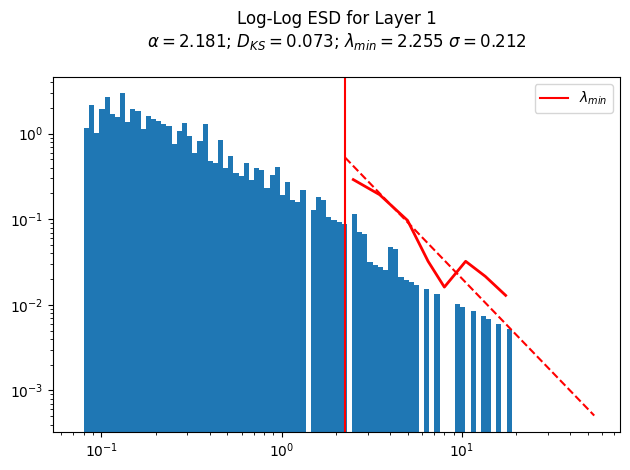

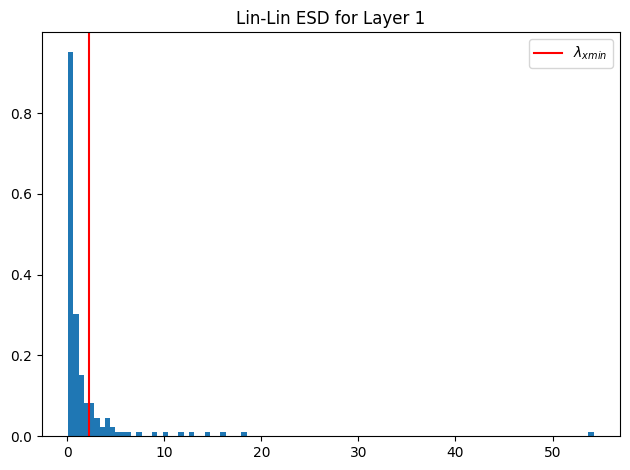

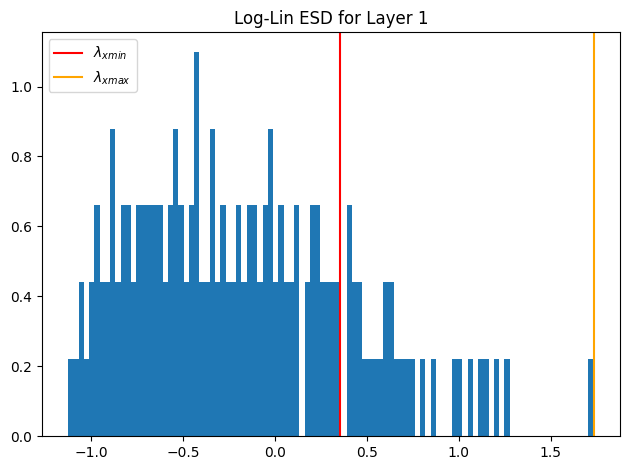

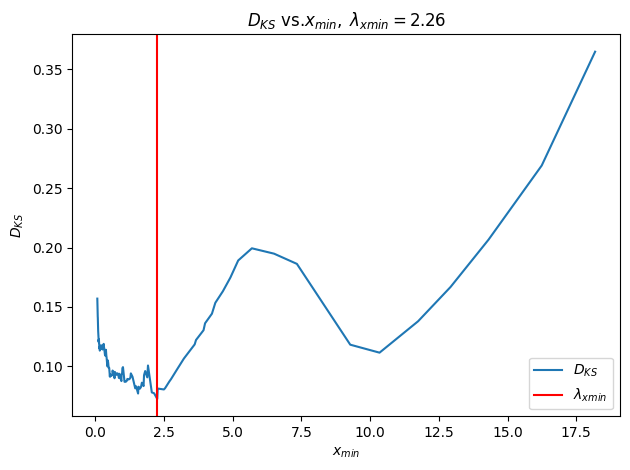

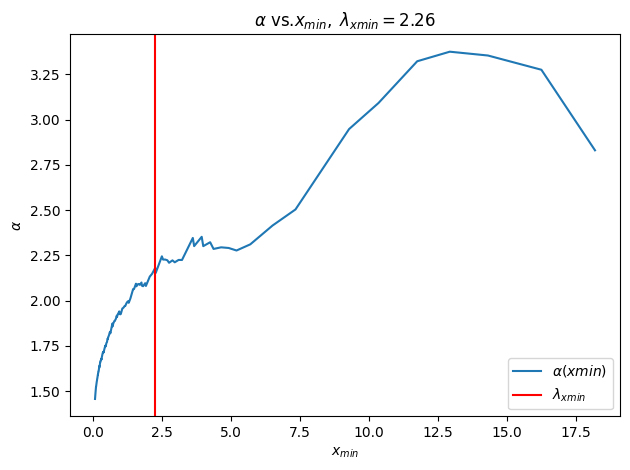

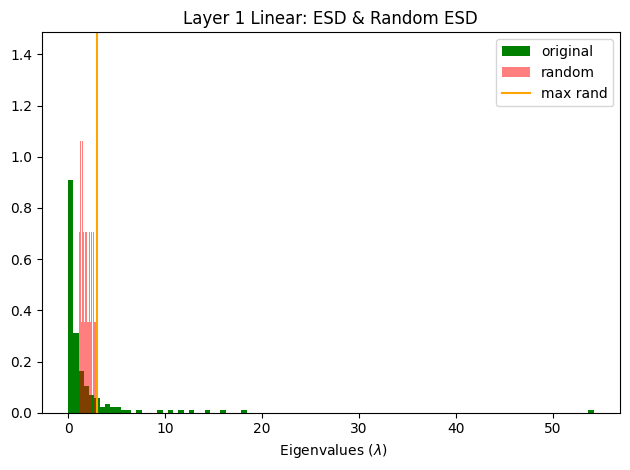

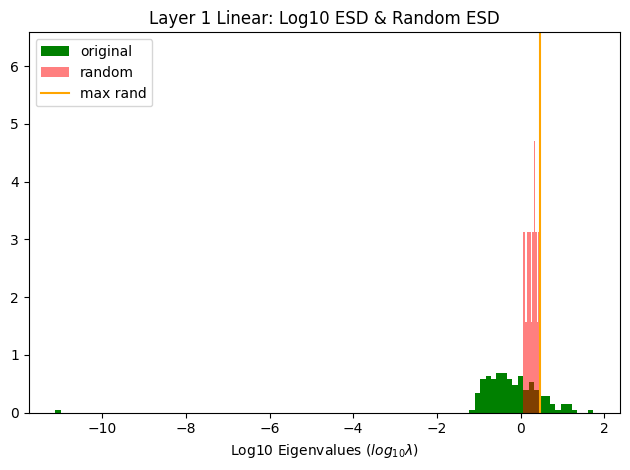

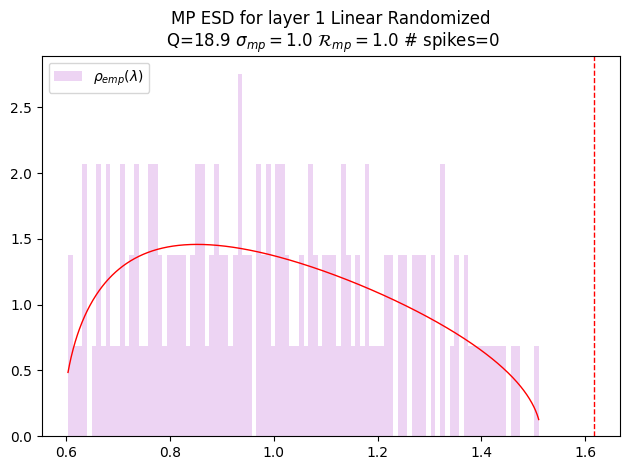

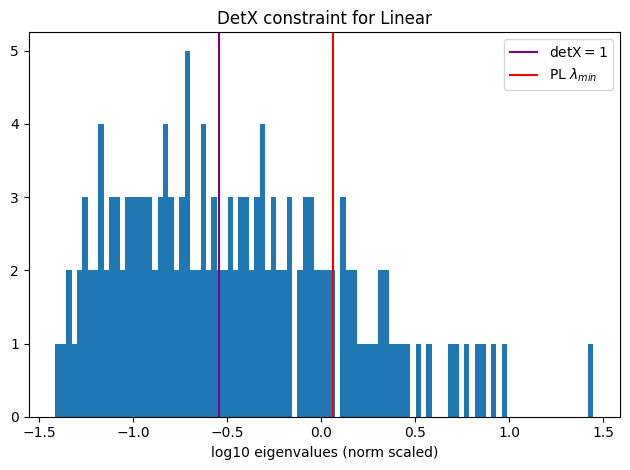


WeightWatcher Diagnostics (W7)
alpha  = 2.181
traps  = 0.0


<Figure size 640x480 with 0 Axes>

In [2]:
# ============================================================
# OpenML "sick" (ID=38) + xgboost2ww + WeightWatcher
#
# Outputs:
#  - Train/Test accuracy both high (99%, 98%)
#  - WeightWatcher  alpha ~ 2.2, no traps
#  - Plot: watcher.analyze(plot=True, randomize=True, detX=True)
#
# ============================================================

!pip -q install "pandas==2.2.2" xgboost weightwatcher scikit-learn openml scipy pyarrow
!apt-get -qq update && apt-get -qq install -y git

# Clone + install xgboost2ww
!rm -rf /content/xgboost2ww
!git clone https://github.com/CalculatedContent/xgboost2ww.git /content/xgboost2ww
!pip -q install -e /content/xgboost2ww

# Fix Colab namespace cache
import sys
sys.path.insert(0, "/content/xgboost2ww/src")
sys.modules.pop("xgboost2ww", None)

from xgboost2ww import convert

import numpy as np
import pandas as pd
import xgboost as xgb
import openml

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

import torch
import weightwatcher as ww

RNG = 0
rng = np.random.default_rng(RNG)
np.random.seed(RNG)

# ------------------------------------------------------------
# Load OpenML "sick" dataset (ID=38)
# ------------------------------------------------------------
ds = openml.datasets.get_dataset(38)
Xdf, y_raw, _, _ = ds.get_data(dataset_format="dataframe", target=ds.default_target_attribute)
print(f"Dataset: {ds.name} (OpenML 38) | rows={len(Xdf)} | cols={Xdf.shape[1]}")

# Factorize binary labels to {0,1}
y_codes, uniques = pd.factorize(y_raw)
y = y_codes.astype(np.int32)
if len(uniques) != 2:
    raise ValueError(f"Expected binary labels; got {len(uniques)} classes: {list(uniques)}")

# ------------------------------------------------------------
# Simple preprocessing: impute + one-hot
# (keep sparse; XGBoost supports CSR)
# ------------------------------------------------------------
cat_cols = Xdf.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in Xdf.columns if c not in cat_cols]

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ]), cat_cols)
], remainder="drop")

X = pre.fit_transform(Xdf)
X = X.tocsr() if hasattr(X, "tocsr") else X

# ------------------------------------------------------------
# True holdout split (never used for OOF/WW)
# ------------------------------------------------------------
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.20, random_state=RNG, stratify=y
)

dtr = xgb.DMatrix(Xtr, label=ytr)
dte = xgb.DMatrix(Xte, label=yte)

# ------------------------------------------------------------
# Train a strong but sane model (sick tends to be learnable)
# ------------------------------------------------------------
params = dict(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    seed=RNG,

    learning_rate=0.05,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    gamma=0.1,
)

bst = xgb.train(
    params=params,
    dtrain=dtr,
    num_boost_round=2000,
    evals=[(dtr, "train"), (dte, "test")],
    early_stopping_rounds=100,
    verbose_eval=False,
)

rounds_used = int(bst.best_iteration + 1)
print("Rounds used:", rounds_used)

# ------------------------------------------------------------
# Evaluate train/test accuracy
# ------------------------------------------------------------
p_tr = bst.predict(dtr).astype(np.float32)
p_te = bst.predict(dte).astype(np.float32)

train_acc = float(accuracy_score(ytr, (p_tr >= 0.5).astype(np.int32)))
test_acc  = float(accuracy_score(yte, (p_te >= 0.5).astype(np.int32)))

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test  accuracy: {test_acc:.3f}")

# ------------------------------------------------------------
# Compute W7 via xgboost2ww.convert()
# IMPORTANT: pass train_params + num_boost_round for reproducibility
# ------------------------------------------------------------
layer_W7 = convert(
    model=bst,
    data=Xtr,
    labels=ytr,
    W="W7",
    nfolds=5,
    t_points=160,
    random_state=RNG,
    train_params=params,
    num_boost_round=rounds_used,
    multiclass="error",
    return_type="torch",
    verbose=False,
)

# ------------------------------------------------------------
# WeightWatcher: ONE plot only
# ------------------------------------------------------------
watcher = ww.WeightWatcher(model=layer_W7)
details_df = watcher.analyze(plot=True, randomize=True, detX=True)

alpha = float(details_df["alpha"].iloc[0]) if "alpha" in details_df.columns else float("nan")
traps = float(details_df["rand_num_spikes"].iloc[0]) if "rand_num_spikes" in details_df.columns else float("nan")

print("\nWeightWatcher Diagnostics (W7)")
print(f"alpha  = {alpha:.3f}")
print(f"traps  = {traps:.1f}")